In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_path = "/content/drive/My Drive/Colab Notebooks/כריית תוכן - עבודה 2/tweets.csv"

In [0]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# QUESTION 1: pre-processing and exploring the dataset

## pre-processing

initialize all resources for pre-processing. we focus on tokenizing tweets in a way that take into account hashtags and tags and emoticons. We also want to eliminate any words or tokens that will not help predict the santiment.

In [0]:
punctuation = list(string.punctuation) #used to eliminate unused punctuations
stop = stopwords.words('english') + punctuation + ['rt', 'via', 'the',u'\u2019',u'\u2026','The',u'de',u'\xe9'] #stop-words
emoticons_str = r"""
    (?:
        [<>]?                       # optional hat/brow
        [:;=8]                      # eyes
        [\-o\*\']?                  # optional nose
        [\)\]\(\[dDpP/\:\}\{@\|\\]  # mouth      
        |                           #### reverse orientation
        [\)\]\(\[dDpP/\:\}\{@\|\\]  # mouth
        [\-o\*\']?                  # optional nose
        [:;=8]                      # eyes
        [<>]?                       # optional hat/brow
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

#creating regex for parsing tokens
numbers_re=re.compile(r'(?:(?:\d+,?)+(?:\.?\d+)?)')
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

#says which tokens to keep. Used to eliminate words that will not help in classifications
def keepTokens(token):
  if token=='' or token[0]=='@' or token[0:4]=='http' or (token in stop) or numbers_re.search(token):
    return False
  return True

#all pre-process happends here by calling other functions
def cleanTweet(text):
  tokens=tokens_re.findall(text) #tokenize
  tokens = ["smileemoticon" if emoticon_re.search(token) else token.lower().replace("#","") for token in tokens] #normalizing emoticons
  tokens = filter(keepTokens,tokens) #eliminating tokens that are not useful
  tokens = map(ps.stem,tokens) #stemming the left tokens
  return " ".join(tokens) #return to one sentance string

In [0]:
data = pd.read_csv(data_path,names=['target','id','time','query','username','text'],engine="python")
data = data[['target','text']]#keep relevant columns
ps = PorterStemmer()
data['text']=data.apply(lambda row: cleanTweet(row['text']),axis=1) #all pre-processing done in here

## exploring the data
we look at the term frequancy/class distibution in each of the santiments and also how many records we have for each santiment. This is needed to make sure that we do not need to make adjustments to help the classifiers



### term distribution
The term distribution is very similar to 'long tail'. There are some popular tokens but **most** of the tokens are only in one or two documents.

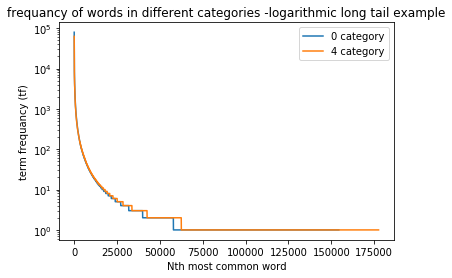

In [0]:
import matplotlib.pyplot as plt

#this function stores counters for each token and santiment
def add_count(target,tokens):
  for token in tokens.split(" "):
    token_counter[target][token]=token_counter[target].get(token,0)+1

#initalize the token counter dictionary
token_counter={0:{},4:{}}

#looping through all records and tokens
data.apply(lambda row: add_count(row['target'],row['text']),axis=1)

#sorting results based on frequancy
token_counter[0]=sorted(token_counter[0].items(), key=lambda kv:kv[1],reverse=True)
token_counter[4]=sorted(token_counter[4].items(), key=lambda kv:kv[1],reverse=True)

#plotting first line for category 0
x=range(0,len(token_counter[0]))
y=[value for (key,value) in sorted(token_counter[0], key=lambda kv: -kv[1])]
plt.plot(x, y,label="0 category")

#plotting second line for category 4
x=range(0,len(token_counter[4]))
y=[value for (key,value) in sorted(token_counter[4], key=lambda kv: -kv[1])]
plt.plot(x, y,label="4 category")

#adding scales and legends
plt.title('frequancy of words in different categories -logarithmic long tail example')
plt.xlabel('Nth most common word')
plt.ylabel('term frequancy (tf)')
plt.yscale('log')
plt.legend(loc='best')

#showing
plt.show()

![alt text](https://drive.google.com/uc?export=view&id=1PLKX8W_ApozuLu2ADiuMPVxc-l2xP3TJ)

<BarContainer object of 20 artists>

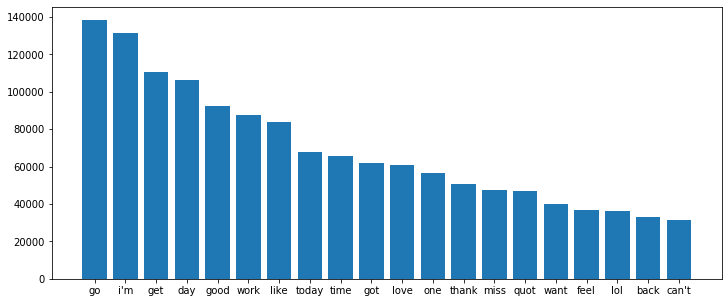

In [0]:
#gathering all popular words from counter
most_popular_words={}
for key in  token_counter[0][:20]:
  most_popular_words[key[0]]=most_popular_words.get(key[0],0)+key[1]
for key in  token_counter[4][:20]:
  most_popular_words[key[0]]=most_popular_words.get(key[0],0)+key[1]

most_popular_words=sorted(most_popular_words.items(), key=lambda kv:kv[1],reverse=True)
most_popular_words_x=[ x[0] for x in most_popular_words[0:20]]
most_popular_words_y=[ x[1] for x in most_popular_words[0:20]]
plt.figure(figsize=(12,5))
plt.bar(most_popular_words_x,most_popular_words_y)

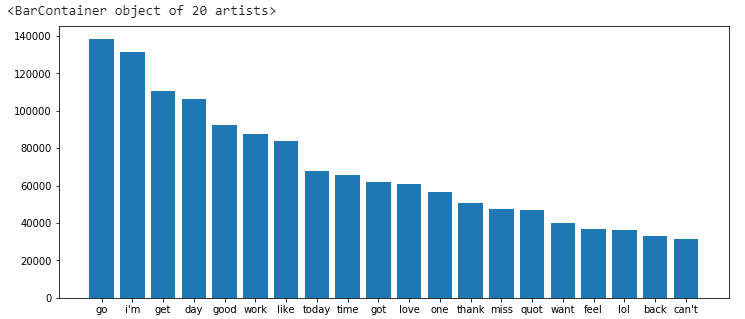

### class distribution
We use it to know if the dataset is balanced because if not we need to make adjustments to it so the classifier will not be biased. Luckily we've seen that the dataset is very balanced.

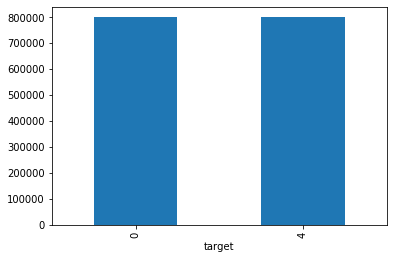

In [0]:
to_plot = data['target'].groupby(data['target']).count() #count occourances of each target attribute in the dataset
to_plot.plot.bar()

![alt text](https://drive.google.com/uc?export=view&id=1uY0yqnaDQxbK3OEzCuU8CUlyRc7-B7Hg)

popular words for each santiment. We already have the count so we show the 10 most found tokens for each santiment

Negative: 


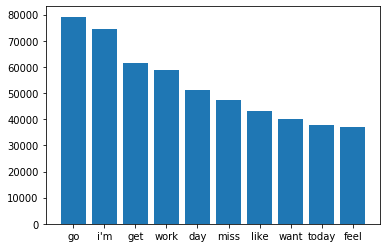

In [0]:
print("Negative: ")

#calculating
x_neg = [i[0] for i in token_counter[0][:10]]
y_neg = [i[1] for i in token_counter[0][:10]]

#plot graph
plt.bar(x_neg,y_neg)
plt.show()

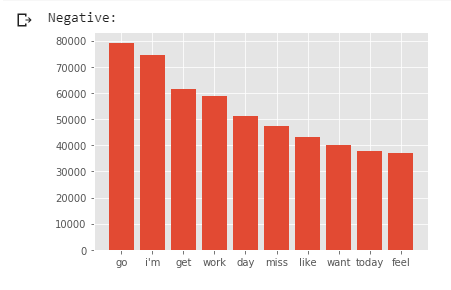

Positive: 


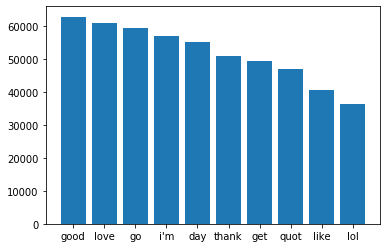

In [0]:
print("Positive: ")
#calculating
x_pos = [i[0] for i in token_counter[4][:10]]
y_pos = [i[1] for i in token_counter[4][:10]]

#plot graph
plt.bar(x_pos,y_pos)
plt.show()

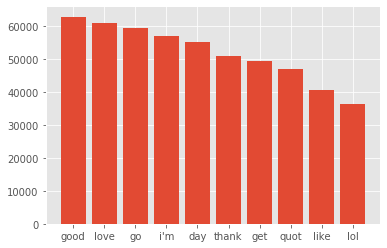

#QUESTION 2: data training and evaluating
*creating* train X, train Y, validation X, validation Y

In [0]:
#in order to split train,validation and test we used this function with data-split ratio of 0.8
def split(data_split):
  train_percent=0.8 
  msk = np.random.rand(len(data_split)) < 0.8
  return data_split[msk],data_split[~msk]

In [0]:
from keras.preprocessing import sequence

#collecting all vocabulary tokens
vocab= set()
vocab.update(i[0] for i in token_counter[0] if i[1] >1000 )
vocab.update(i[0] for i in token_counter[4]  if i[1] >1000)
vocab_to_int = {w:i+1 for i, w in enumerate(vocab)}

#parsing to number series
def tweet_to_series(tweet):
  words=tweet.split()
  return list(map(lambda x:vocab_to_int[x] if x in vocab_to_int  else 1000,words))
data['encoded']=data.apply(lambda row: tweet_to_series(row['text']),axis=1)

Using TensorFlow backend.


In [0]:
#splitting the data into 3 parts.
train , test = split(data)
train, val = split(train)

corpus_train=[text for text in train['text']] #crating the records for TRAIN-SET
corpus_val=[text for text in val['text']] #crating the records for VALIDATION-SET
corpus_test = [text for text in test['text']]  #crating the records for TEST-SET

#for keras model:
max_length = 300
X_train_K = sequence.pad_sequences(train['encoded'], maxlen=max_length)
X_validation_K = sequence.pad_sequences(val['encoded'], maxlen=max_length)
X_test_K = sequence.pad_sequences(test['encoded'], maxlen=max_length)

In [0]:
X_train_K

array([[   0,    0,    0, ..., 1000,  355,  683],
       [   0,    0,    0, ...,   99,  287, 1000],
       [   0,    0,    0, ..., 1000,  542,  463],
       ...,
       [   0,    0,    0, ...,  141,  954, 1000],
       [   0,    0,    0, ..., 1000,  202, 1000],
       [   0,    0,    0, ...,    0,  548, 1000]], dtype=int32)

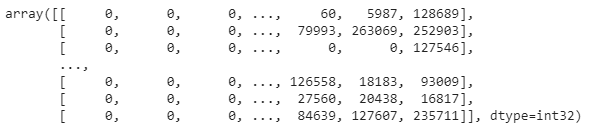

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer after tuning hyper-parameters
vectorizer = TfidfVectorizer(min_df=0.001,max_features=500)

#turning tweets to numeric vectors
X_train = vectorizer.fit_transform(corpus_train).toarray()
X_validation = vectorizer.transform(corpus_val).toarray()

#turning labels to numeric values in binary
Y_train = np.asarray([0 if text==0 else 1 for text in train['target']])
Y_validation=np.asarray([0 if text==0 else 1 for text in val['target']])

In [0]:
#adding test records
X_test = vectorizer.transform(corpus_test).toarray()
Y_test=np.asarray([0 if text==0 else 1 for text in test['target']])

In [0]:
print("num of attributes",str(len(vectorizer.get_feature_names())))

num of attributes 500


### KERAS MODEL

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras import layers
from keras.layers import LSTM,Dense,Dropout,Flatten,CuDNNLSTM,Bidirectional,Embedding,RepeatVector,Input,concatenate,Reshape,Concatenate
input_dim = X_train_K.shape[1]

#model layers creation
model_lstm = Sequential()
model_lstm.add(Embedding(300, 32, input_length=max_length))
model_lstm.add(Dropout(0.2))
model_lstm.add(CuDNNLSTM(100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1,activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])


print(model_lstm.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           9600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 32)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               53600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 63,301
Trainable params

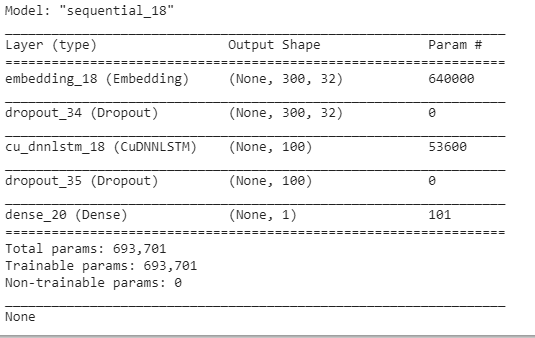

In [0]:
history = model_lstm.fit(X_train_K, Y_train,epochs=10,verbose=1,validation_data=(X_validation_K, Y_validation), batch_size=2048)




Train on 1023921 samples, validate on 256141 samples
Epoch 1/10





1023921/1023921 [==============================] - 74s 72us/step - loss: 0.6233 - acc: 0.6272 - val_loss: 0.6119 - val_acc: 0.6376
Epoch 2/10
1023921/1023921 [==============================] - 60s 59us/step - loss: 0.6124 - acc: 0.6368 - val_loss: 0.6102 - val_acc: 0.6371
Epoch 3/10
1023921/1023921 [==============================] - 60s 59us/step - loss: 0.6108 - acc: 0.6381 - val_loss: 0.6092 - val_acc: 0.6389
Epoch 4/10
1023921/1023921 [==============================] - 60s 59us/step - loss: 0.6098 - acc: 0.6388 - val_loss: 0.6081 - val_acc: 0.6395
Epoch 5/10
1023921/1023921 [==============================] - 60s 59us/step - loss: 0.6090 - acc: 0.6400 - val_loss: 0.6081 - val_acc: 0.6400
Epoch 6/10
1023921/1023921 [==============================] - 60s 59us/step - loss: 0.6084 - acc: 0.6405 - val_loss: 0.6069 - val_acc: 0.6415
Epoch 7/10
1023921/1023921 [==============================] - 60s 59us/step - loss: 0.6

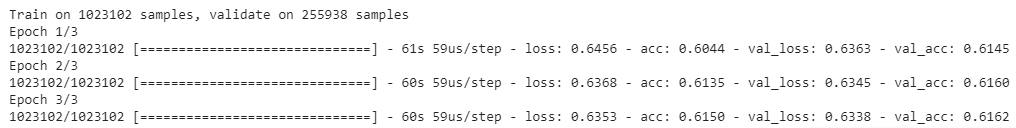

we want to see that we did not reach overfit by looking at accuracy through train and validation sets.

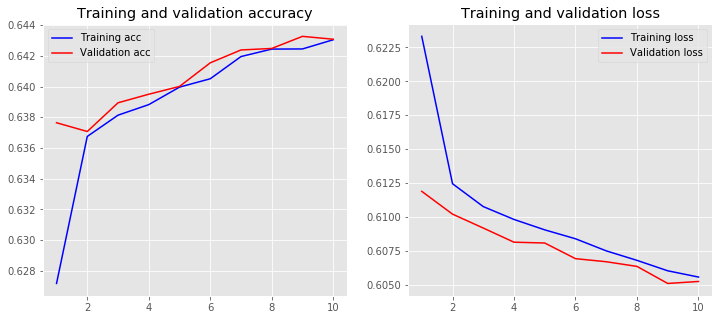

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#this function plots history of keras lerner
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    #creating a figure to the sets
    plt.figure(figsize=(12, 5))

    #creating accuracy graph
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #creating loss graph
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

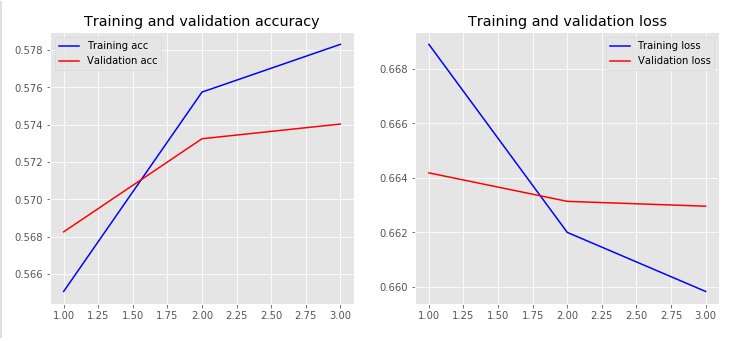

### RANDOM FOREST MODEL

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=0, n_jobs=-1)
model.fit(X_train,Y_train)
predictions=model.predict(X_validation)

In [0]:
print("val acc:",accuracy_score(Y_validation, predictions))

val acc: 0.6801819327829179


val acc: 0.6801819327829179

### results on test-set

In [0]:
#model random forest
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
print("train acc: ",accuracy_score(Y_train, predict_train))
print("test acc: ",accuracy_score(Y_test, predict_test))

train acc:  0.6802678384599289
test acc:  0.67964505613908


In [0]:
#predict lstm:
# predict_train =model_lstm.predict(X_train_K)
# predict_test = model_lstm.predict(X_test_K)
print("train acc: ",model_lstm.evaluate(X_train_K,Y_train))
print("test acc: ",model_lstm.evaluate(X_test_K,Y_test))


1022706/1022706 [==============================] - 205s 201us/step
train acc:  [0.6569857456837168, 0.5820186837662835]
320276/320276 [==============================] - 64s 200us/step
test acc:  [0.6615020150071944, 0.5761374564441895]


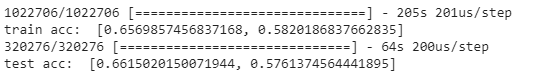

# QUESTION 3: twitter mining

In [0]:
!pip3 install tweepy
twitter_count = 0
twitter_test_list = []

## connecting to twitter via tweepy
we use our API application secret access token that we have. After registering we authorize ourselves

In [0]:
import tweepy
from tweepy import OAuthHandler
import json

consumer_key = 'Rc8swIlsqqnkwlWLAX7bSlDCS'
consumer_secret = 'U5l7VP0eAKLeGADry1U8GmPheCHQANUERCxOiV3skRwJffXvJ9'
access_token = '1228316409916272645-GoRF4x9OGr8hwyo9mVj8kHpjE0ECPM'
access_secret = 'YgnMbeLIPLQE4zJ2PlZlP5ySWQ7Tox1s3gslX42EMsK7Y'

auth = OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

function for collecting data. It appends the data to the twitter_test_list that we eant to use later

In [0]:
import tweepy
twitter_test_list = []

#override tweepy.StreamListener to add logic to on_status
class MyStreamListener(tweepy.StreamListener):
  def on_data(self, data):
        try:
          y = json.loads(data)
          twitter_test_list.append(y['text']) #adding the new tweet to the list
          if len(twitter_test_list) == 15000: #knowing to stop at 15000 that this is our limit
            return False
          return True
        except BaseException as e:
            # print("Error on_data: %s" % str(e))
            pass
        return True
  
  def on_error(self, status):
        print(status)
        return True

In [0]:
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)

In [0]:
#filter the tweets by using common words to get English only random tweets LIVE
myStream.filter(languages=["en"],track=['a','i','am','is','tired'])

In [0]:
print(len(twitter_test_list))

15000


In [0]:
#we added option to write to file so we can debug without mining a lot from twitter. It is for personal use
import_from_file=False #in use if we want to save to file. For developers use only
if import_from_file:
  with open('twitter_test_list.txt', 'a') as f:
      for item in twitter_test_list:
          f.write("%s\n" % item)
  with open('/content/drive/My Drive/Colab Notebooks/כריית תוכן - עבודה 2/twitter_test_list.txt') as f:
    twitter_test_list = f.read().splitlines()

## preprocessing tweets

In [0]:
twitter_test_list_df = pd.DataFrame(twitter_test_list,columns=["text"]) #adding tweets to a dataframe

In [0]:
twitter_test_list_df['text']=twitter_test_list_df.apply(lambda row: cleanTweet(row['text']),axis=1) #pre-processing tweets

## tag tweets
we use the automated textBlob package to find the tags for the tweets that use exeternal ways and not the model we created

In [0]:
from textblob import TextBlob 

In [0]:
def get_tweet_sentiment(tweet): 
  ''' 
  Utility function to classify sentiment of passed tweet 
  using textblob's sentiment method 
  '''
  # create TextBlob object of passed tweet text 
  analysis = TextBlob(tweet) 
  # set sentiment 
  if analysis.sentiment.polarity > 0: 
      return 1 #positive
  else:
    return 0

In [0]:
#calling the labeling function we created
twitter_test_list_df['target'] = twitter_test_list_df.apply(lambda row: get_tweet_sentiment(row['text']),axis=1) 

In [0]:
twitter_test_list_df

,text,target
0,exert littl mental energi dumb come natur thin...,0
1,tri sassa sure disabl u claim 🚶 🏿 ‍ ♀ ️ 🚶 🏿 ‍ ...,1
2,actual deliv latino ✅ record-low unemploy ✅ re...,0
3,bachelor guy make k episod entertain girl im b...,0
4,agre better idea pick one measur experi sm,1
...,...,...
14995,well obvious templ alon go magic gdp limit point,1
14996,spokesperson grenel us embassi berlin respond ...,0
14997,ain't real enough midwest trust,0
14998,“ hello everyon kang daniel design present kan...,0


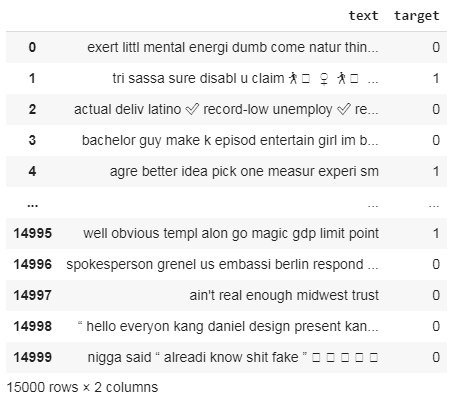

## plotting Graphs
now we look at popular terms and class distribution while exploring the data

firstly, term distribution

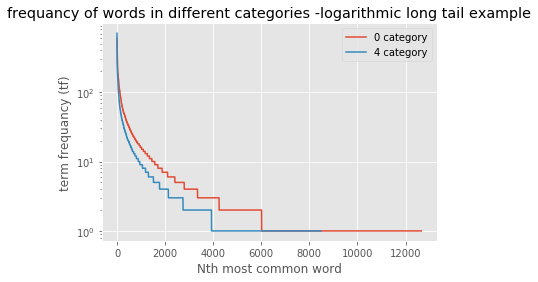

In [0]:
import matplotlib.pyplot as plt

def add_count(target,tokens):
  for token in tokens.split(" "):
    token_counter[target][token]=token_counter[target].get(token,0)+1

#init counters
token_counter={0:{},1:{}}
twitter_test_list_df.apply(lambda row: add_count(row['target'],row['text']),axis=1)
token_counter[0]=sorted(token_counter[0].items(), key=lambda kv:kv[1],reverse=True)
token_counter[1]=sorted(token_counter[1].items(), key=lambda kv:kv[1],reverse=True)

#plotting first graph
x=range(0,len(token_counter[0]))
y=[value for (key,value) in sorted(token_counter[0], key=lambda kv: -kv[1])]
plt.plot(x, y,label="0 category")

#plotting second graph
x=range(0,len(token_counter[1]))
y=[value for (key,value) in sorted(token_counter[1], key=lambda kv: -kv[1])]
plt.plot(x, y,label="4 category")

#adding labels for the plot
plt.title('frequancy of words in different categories -logarithmic long tail example')
plt.xlabel('Nth most common word')
plt.ylabel('term frequancy (tf)')
plt.yscale('log')
plt.legend(loc='best')

#view graph
plt.show()

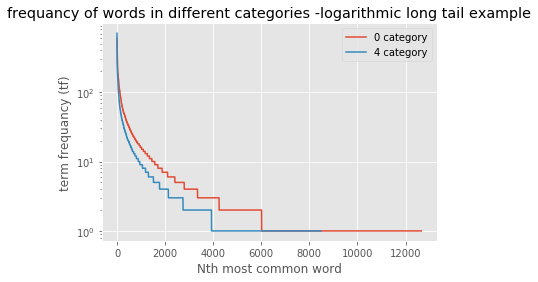

class distribution

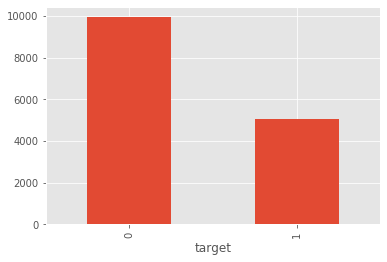

In [0]:
to_plot = twitter_test_list_df['target'].groupby(twitter_test_list_df['target']).count()
to_plot.plot.bar()

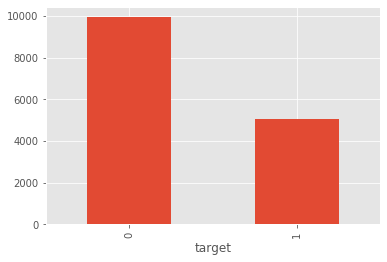

###  popular terms in distribution

show first 10 samples of each label

In [0]:
print("Negative: ")
token_counter[0][:10]

Negative: 


[('like', 590),
 ('“', 582),
 ('one', 493),
 ('get', 475),
 ('”', 427),
 ('amp', 407),
 ('know', 389),
 ('go', 389),
 ('want', 389),
 ('😂', 386)]

Negative: 
[('like', 590),
 ('“', 582),
 ('one', 493),
 ('get', 475),
 ('”', 427),
 ('amp', 407),
 ('know', 389),
 ('go', 389),
 ('want', 389),
 ('😂', 386)]

In [0]:
x_neg = [i[0] for i in token_counter[0][:10]]
y_neg = [i[1] for i in token_counter[0][:10]]

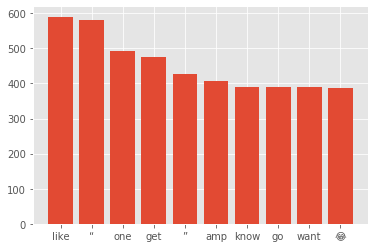

In [0]:
plt.bar(x_neg,y_neg)
plt.show()

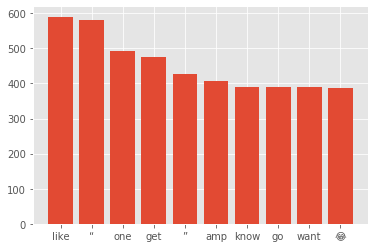

In [0]:
print("Positive: ")
token_counter[1][:10]

Positive: 


[('love', 706),
 ('new', 479),
 ('good', 366),
 ('like', 363),
 ('“', 297),
 ('one', 288),
 ('right', 269),
 ('get', 258),
 ('time', 251),
 ('much', 234)]

Positive: 
[('love', 706),
 ('new', 479),
 ('good', 366),
 ('like', 363),
 ('“', 297),
 ('one', 288),
 ('right', 269),
 ('get', 258),
 ('time', 251),
 ('much', 234)]

In [0]:
x_pos = [i[0] for i in token_counter[1][:10]]
y_pos = [i[1] for i in token_counter[1][:10]]

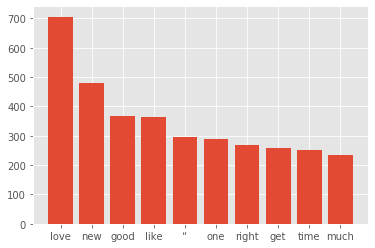

In [0]:
plt.bar(x_pos,y_pos)
plt.show()

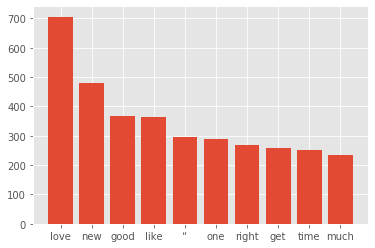

# QUESTION 4: predicting tweets using Machine Learning
we see how the distribution is different as well as the words.
It makes sense that the **same popular terms** in the training are same in the mining because the language of twitter is the same language in both, even though they are not always describe one santiment. For example, 'day' is quite neutral.

Because we used textBlob we received the label tags from it but we do not know how it works. The dataset in the training was tagged by humans or by expert analysis that knew they were **classifying tweets** but the textBlob is for **classyfing all documents** so twitter slang or hashtags or tags are not always classified correctly.

also, because we used the same pre-processing **textBlob got stemmed words** but it does not know how to handle them

moreover, it was taken in a period of time and if something positive happend at **the time when we were mining** it could make the result biased towards the time of day or the date.




## Random forest

because the random forest was more accurate we decided to use him. We used the same model and hyper-parameters for it.

In [0]:
X_test_Q4 = vectorizer.transform([x for x in twitter_test_list_df['text']]).toarray()

In [0]:
#model of random forest predictions
predict_test = model.predict(X_test_Q4)
print("test acc: ",accuracy_score(twitter_test_list_df['target'], predict_test))

test acc:  0.4282


test acc:  0.4282

## conclusions
sadly, because the tagging process was different the random forest model is not trained to fit the textBlob tagging process so the results are not as good.

One of the reasons was that the tweets are not from the same source and time (**mining by different rules**, times).

other reason is that the **tagging process of TextBlob** does not always match our training process of training.

using the API we received **words that the model did not know** so it could not handle (similar to the regular test-set we had). If we had more tweets maybe we could have gotten better results.

also, maybe if we had more experience with Keras we could make **better architecture** than **first try**. Because we do not have much experience in building **LSTM** models the results are not satisfying


